**Решение создано в Yandex DataSphere**

# Загрузка необходимых библиотек

In [ ]:
#!L
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import catboost as cat
import xgboost as xgb
from scipy.signal import savgol_filter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
#!L
data_dir = './'

Страницы 22-30 из скачанного файла (Семинар 4.pdf)

# Загрузка данных

In [ ]:
#!L
train = pd.read_csv(data_dir + '/train.csv')
test = pd.read_csv(data_dir + '/test.csv')

# Переименование столбцов

In [ ]:
#!L
columns_train = ['year', 'fieldId', 'fieldArea']

for i in range(3, len(train.columns) - 1):
    columns_train.append(i - 2)

columns_train.append('culture')

train.columns = columns_train
test.columns = columns_train[:-1]
classes = train['culture'].unique()

# График вегетации

In [ ]:
#!L
def plot_vegetation(row, i):
    fig, ax = plt.subplots(figsize=(15, 5))
    row = np.array(row)
    ax.plot([x for x in range(len(row))],
            row,
            color='red')
    ax.plot([x for x in range(len(row))],
            [0 for _ in range(len(row))],
            color='#632D08')
    ax.plot([x for x in range(0, 2)],
            color='#632D08')
    ax.grid()
    ax.set(xlabel="Day",
           ylabel="Veg",
           title='Vegetation {}'.format(i))

    plt.show()

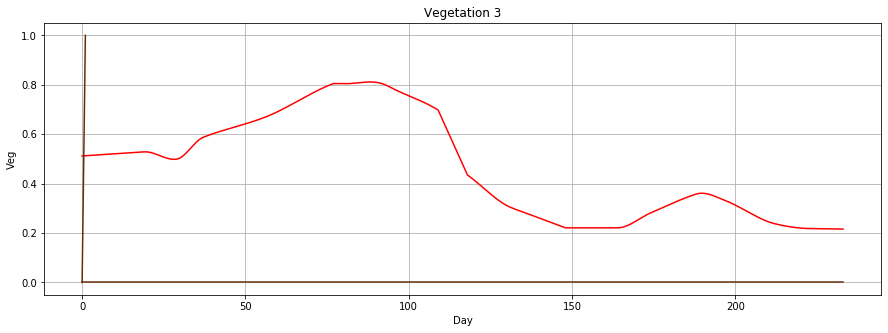

In [ ]:
#!L
for e in range(3, 4):
    plot_vegetation(train[train.columns[45:279]].iloc[e], e)

# Функции создания датафрейма

В качестве фичей были выбраны значения по дням с различным периодом, значений скоростей изменения индекс с различным периодом. Также добавлены значения квантилей, среднее, сумма, а также количество дней выше некоторых квантилей.

In [ ]:
#!L
def speeds_dataframe(days, every_speed=True, period_speed=False, period=7):

    result = pd.DataFrame()

    def speeds_every_day(df):
        df.columns = [x for x in range(df.shape[1])]
        speeds = pd.DataFrame()
        for i in range(df.shape[1]-1):
            speeds['{}_speed'.format(i)] = df[i+1] - df[i]
        return speeds

    def speeds_mean_periods(df, period):
        df.columns = [x for x in range(df.shape[1])]
        speeds = pd.DataFrame()
        for i in range(0, df.shape[1]+1-period, period):
            speeds['{}_speed_period'.format(i)] = df[i+period-1] - df[i]
        return speeds

    result_every_speed = speeds_every_day(days)
    if every_speed:
        result = pd.concat([result, result_every_speed], axis=1)

    if period_speed:
        result_period_speed = speeds_mean_periods(days, period)
        result = pd.concat([result, result_period_speed], axis=1)


    result['speed_mean'] = result_every_speed.apply('mean', axis=1)
    result['speed_sum'] = result_every_speed.apply('sum', axis=1)

    for i in range(0, 101, 10):
        def quantile(row):
            return row.quantile(i/100)
        result['speed_quant_{}'.format(i)] = result_every_speed.apply(quantile, axis=1)

    for i in range(0, 81, 10):
        def speed_count(row):
            t_value = row.quantile(i/100)
            sc = 0
            for elem in row:
                if elem >= t_value:
                    sc += 1
            return sc
        def speed_sum(row):
            t_value = row.quantile(i/100)
            ss = 0
            for elem in row:
                if elem >= t_value:
                    ss += elem
            return ss
        result['{}_speed_count'.format(i)] = result_every_speed.apply(speed_count, axis=1)
        result['{}_speed_sum'.format(i)] = result_every_speed.apply(speed_sum, axis=1)

    return result

In [ ]:
#!L
def days_dataframe(days, every_day=True, period_day=False, period=7):
    
    result = pd.DataFrame()
    
    def day_every(df):
        df.columns = ['{}_day'.format(x) for x in range(df.shape[1])]
        return df
    
    def day_periods(df, period):
        df.columns = [x for x in range(df.shape[1])]
        periods = pd.DataFrame()
        for i in range(0, df.shape[1], period):
            periods['{}_day_period'.format(i)] = df[i]
        return periods
    
    if every_day:
        result = pd.concat([result, day_every(days)], axis=1)

    if period_day:
        result_period_day = day_periods(days, period)
        result = pd.concat([result, result_period_day], axis=1)


    result['day_mean'] = days.apply('mean', axis=1)
    result['day_sum'] = days.apply('sum', axis=1)

    for i in range(0, 101, 10):
        def quantile(row):
            return row.quantile(i/100)
        result['day_quant_{}'.format(i)] = days.apply(quantile, axis=1)

    for i in range(0, 81, 10):
        def day_count(row):
            t_value = row.quantile(i/100)
            sc = 0
            for elem in row:
                if elem >= t_value:
                    sc += 1
            return sc
        def day_sum(row):
            t_value = row.quantile(i/100)
            ss = 0
            for elem in row:
                if elem >= t_value:
                    ss += elem
            return ss
        result['{}_day_count'.format(i)] = days.apply(day_count, axis=1)
        result['{}_day_sum'.format(i)] = days.apply(day_sum, axis=1)

    return result

In [ ]:
#!L
def make_dataframe(data, every_speed=False, period_speed=True, period_s=7, every_day=True, period_day=False, period_d=7):
    
    days = data[data.columns[45:279]]    
    result = pd.DataFrame()
    result = pd.concat([result, speeds_dataframe(days, every_speed, period_speed, period_s)], axis=1)
    result = pd.concat([result, days_dataframe(days, every_day, period_day, period_d)], axis=1)
    result = pd.concat([result, data['fieldArea']], axis=1)
    
    return result

# Сэмплирование

Реализована функция случайного сэмплирования с обязательным добавлением редких культур в трейн. Такое сэмплирование избавляет от недостатков kfold и позволяет проводить кросс-валидацию.

In [ ]:
#!L
def get_sample(X, y, rand_seed, size):
    sample_dict = round(size * train.groupby('culture').year.count().sort_values()).astype(int).to_dict()
    X_sample = pd.DataFrame()
    y_sample = pd.Series(dtype=int)
    for key in sample_dict:
        X_sample = pd.concat([X_sample, 
                              X[y == key].sample(sample_dict[key], random_state=rand_seed)])
        y_sample = pd.concat([y_sample, 
                              y[X[y == key].sample(sample_dict[key], random_state=rand_seed).index]])
    X_val = X[~X.index.isin(X_sample.index)]
    y_val = y[~y.index.isin(y_sample.index)]
    return X_sample, y_sample, X_val, y_val

# Функции для предикта

In [ ]:
#!L
def encode_predict_proba(pp):
    res = []
    for i in range(pp.shape[0]):
        res.append(classes[np.where(pp[i] == pp[i].max())[0][0]])
    return res

In [ ]:
#!L
def dist_res(pred):
    temp = pd.DataFrame(pred, columns=['pred']).reset_index()
    temp = pd.DataFrame(temp.groupby('pred').index.count().sort_values(ascending=False)).reset_index()
    temp = temp.rename(columns={'index': 'culture'})
    plt.rcParams["figure.figsize"] = (15,5)
    ax = temp.plot('pred', 'culture', kind='bar', color='c', fontsize=14)
    ax.set_title("Distribution of crops", fontsize = 14)

    rects = ax.patches

    labels = temp['culture']

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

# Выбор эффективных датафреймов

In [ ]:
#!L
def check_data(X, y, test, size=0.85):
    
    score = 0
    predicts = np.zeros((test.shape[0], len(classes)))
    k = 0
    for rs in range(17, 27):
        X_train, y_train, X_test, y_test = get_sample(X, y, rs, size)
        model = cat.CatBoostClassifier(
                        random_seed=rs,
                        early_stopping_rounds=500,
                        l2_leaf_reg=0.1,
                        class_names=classes,
                        auto_class_weights='Balanced',
                        bagging_temperature=1,
                        eval_metric='TotalF1',
                        loss_function='MultiClassOneVsAll',
                        task_type='GPU',
                        devices='0:1',
                        verbose=False
                        )
        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        score_temp = metrics.f1_score(y_test, model.predict(X_test), average='weighted')
        if score_temp > 0.91:
            k += 1
            score += score_temp
            predicts += model.predict_proba(test)
    if k > 0:
        print(score / k)
        dist_res(encode_predict_proba(predicts))
        return predicts
    else:
        print(0)
        return 0

In [ ]:
#!L
data_params = [
    [True, False, 7, False, True, 3],
    [True, False, 7, False, True, 7],
    [False, True, 3, True, False, 3],
    [False, True, 7, True, False, 3]
]

In [ ]:
#!L
i = 1
preds = np.zeros((test.shape[0], len(classes)))
for dp in data_params:
    X = make_dataframe(train, dp[0], dp[1], dp[2], dp[3], dp[4], dp[5])
    y = train['culture']
    test_x = make_dataframe(test, dp[0], dp[1], dp[2], dp[3], dp[4], dp[5])
    print('{}/{}: data ready...'.format(i, len(data_params)), dp)
    i += 1
    preds += check_data(X, y, test_x)

# Получение предикта

In [ ]:
#!L
def get_pred(X, y, test, params, size=0.9):
    
    score = 0
    predicts = np.zeros((test.shape[0], len(classes)))
    k = 0
    j = 0
    print('30 times:', end=' ')
    for rs in range(17, 47):
        print(j, end='...')
        j += 1
        params['random_seed'] = rs
        X_train, y_train, X_test, y_test = get_sample(X, y, rs, size)
        model = cat.CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        score_temp = metrics.f1_score(y_test, model.predict(X_test), average='weighted')
        if score_temp > 0.9:
            print('find', end='...')
            k += 1
            score += score_temp
            predicts += score_temp * model.predict_proba(test)
    print()
    if k > 0:
        print(score / k)
        dist_res(encode_predict_proba(predicts))
        return predicts
    else:
        print(0)
        return 0

In [ ]:
#!L
params = {
    'iterations': 2000,
    'depth': 6,
    'early_stopping_rounds': 500,
    'l2_leaf_reg': 5,
    'bagging_temperature': 1,
    'random_seed': 17,
    'class_names': classes,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'TotalF1',
    'loss_function': 'MultiClassOneVsAll',
    'task_type': 'GPU',
    'devices': '0:1',
    'verbose': False
}

In [ ]:
#!L
data_params = [
    [True, False, 7, False, True, 2],
    [True, False, 2, False, True, 4],
]

1/2: data ready... [True, False, 7, False, True, 2]
30 times: 0...1...2...3...4...find...5...find...6...7...find...8...9...find...10...11...12...13...14...15...16...17...18...19...20...21...22...23...find...24...25...find...26...27...28...find...29...
0.914748884628297


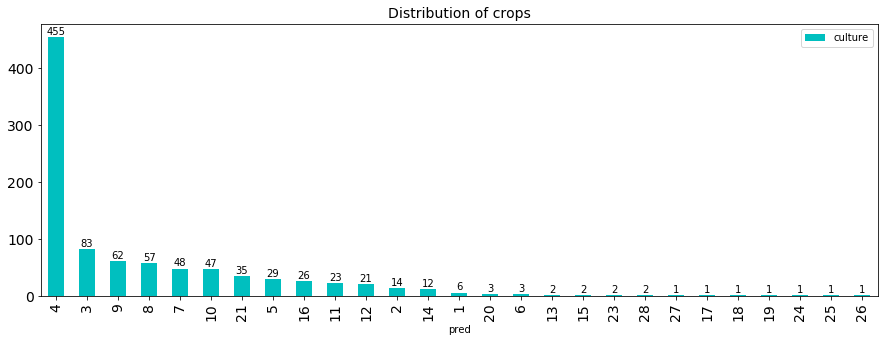

2/2: data ready... [True, False, 2, False, True, 4]
30 times: 0...1...find...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...find...19...20...21...22...23...find...24...25...find...26...27...28...find...29...
0.9064906004031851


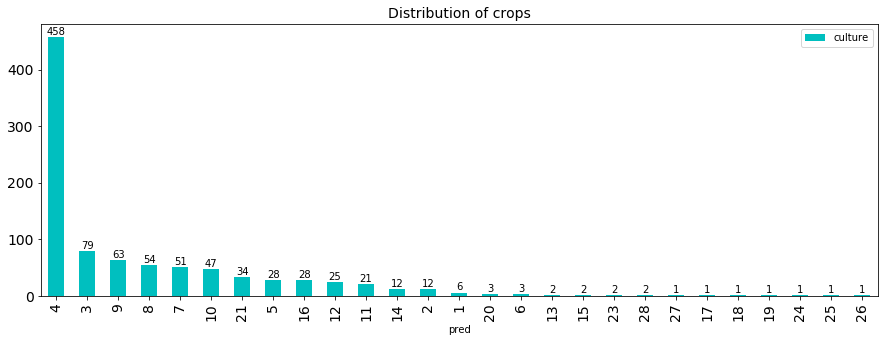

In [ ]:
#!L
i = 1
preds = []
for dp in data_params:
    X = make_dataframe(train, dp[0], dp[1], dp[2], dp[3], dp[4], dp[5])
    y = train['culture']
    test_x = make_dataframe(test, dp[0], dp[1], dp[2], dp[3], dp[4], dp[5])
    print('{}/{}: data ready...'.format(i, len(data_params)), dp)
    i += 1
    preds.append(get_pred(X, y, test_x, params))

**Финальное распределение таргета**

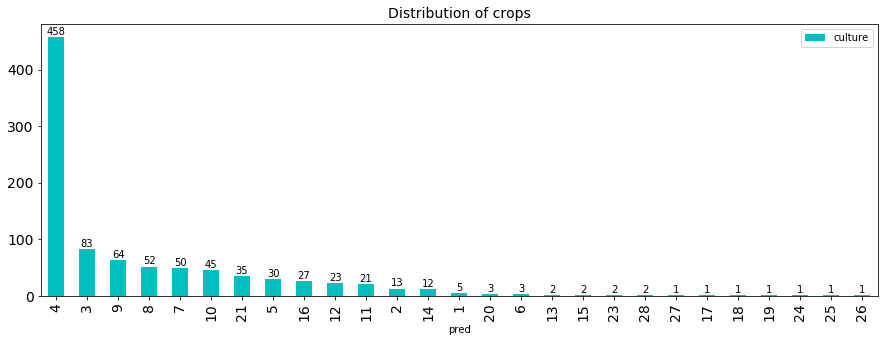

In [ ]:
#!L
dist_res(encode_predict_proba(preds[0] + preds[1]))

In [ ]:
#!L
pd.DataFrame(encode_predict_proba(preds[0] + preds[1]), index=[x for x in range(1, 940)], columns=['Culture']).to_csv('result.csv', index=False)